# Stable Diffusion丸わかり パート2 Text Inversion編
Grokking SD part 2 Text Inversion

# はじめに

_Jonathan Whitaker氏(Twitter: [@johnowhitaker](https://twitter.com/johnowhitaker))がより詳しく解説をした、2本のノートブック([Part 1 - 基本編](https://colab.research.google.com/drive/1dlgggNa5Mz8sEAGU0wFCHhGLFooW_pf1?usp=sharing), [Part 2 - Text Inversion解説](https://colab.research.google.com/drive/1RTHDzE-otzmZOuy8w1WEOxmn9pNcEz3u?usp=sharing))を作成しています。氏のご厚意で、これらのソースコード、及び解説の翻訳、再頒布に了解をいただきました。以降は、Part 1ノートブックを元に、tomo-makes (Twitter: [@tomo_makes](https://twitter.com/tomo_makes))にて翻訳、加筆を行なったものです。_


これは、数日前に共有した ['Grokking Stable Diffusion'](https://colab.research.google.com/drive/1dlgggNa5Mz8sEAGU0wFCHhGLFooW_pf1?usp=sharing) (訳者注: [Stable Diffusionまるわかり! Part 1ノートブック 日本語版](https://colab.research.google.com/github/tomo-makes/sd-notebooks/blob/master/Grokking_Stable_Diffusion_ja.ipynb)
) というノートブックの続編で、SDの構成要素とそれで何ができるかを非公式に深堀りしたものです。

![birb embeddings eg](https://huggingface.co/sd-concepts-library/birb-style/resolve/main/birb_examples.jpeg)
_このスタイルの単語を学習するためにTextual Inversionを使用して作成された画像_

同じように、このノートブックでは、パート1では触れられなかった概念、つまりTextual Inversionの探求を記録していきます。この論文は素晴らしく、コードを一般に公開されています。ただ、ここでは練習として、理解を深めるためにそれらを再実装して、見ていきましょう。

Hugging Faceチームからも[ドキュメント](https://huggingface.co/docs/diffusers/main/en/training/text_inversion)が出されており、学習や推論ノートブックへのリンクがあります。ご自身で、まずText Inversionの学習から試したい場合は、こちらのノートブックの方が良いかもしれません。ここでは、コードで詳細を調べることに焦点を当てます。

### 背景（前述のドキュメントにも記載あり）

Text Inversionは、少ないサンプル画像から新しい概念を学習し、Text-to-Imageのパイプラインで画像生成制御に使えるようにする技術です。これは、テキストエンコーダの埋め込み空間に、新しい「単語」を学習、獲得することで可能になります。学習した特別な「単語」は、テキストプロンプトの中で使えるようになります。例えば、「一般的な」ねこという指定ではなく、「自分の家のねこ」を、生成される画像に登場させる、といったとても細やかな制御ができるようになります。

![テキストインバージョンの例](https://textual-inversion.github.io/static/images/editing/colorful_teapot.JPG)

_3～5枚の画像を使用するだけで、Stable Diffusionのようなモデルに新しい概念を教え、パーソナライズされた画像生成を行えます([画像ソース](https://github.com/rinongal/textual_inversion))_

この手法は、[An Image is Worth One Word: Personalizing Text-to-Image Generation using Textual Inversion](https://arxiv.org/abs/2208.01618)で紹介されています。この論文では、[Latent Diffusion Model](https://github.com/CompVis/latent-diffusion)を使ってコンセプトを示しています。その後、このアイデアはStable Diffusionのような他のバリエーションに展開、適用されています。


# セットアップ

![setup gif](https://c.tenor.com/H7TvEk2l-QoAAAAM/im-the-set-up-guy-set-up.gif)

必要なライブラリをインストールする:

In [ ]:
!pip install transformers diffusers==0.2.4 # アップデートにより互換性が失われる可能性があるのでバージョンを指定

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 14.2 MB/s 
     |████████████████████████████████| 112 kB 66.6 MB/s 
     |████████████████████████████████| 6.6 MB 51.5 MB/s 
     |████████████████████████████████| 120 kB 71.2 MB/s 


HubからStable Diffusionモデルをダウンロードする前に、Hugging Faceのアカウントを取得し、ライセンスに同意する必要があります。

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


これで、必要なものをすべてインポートし、モデルをロードすることができます。もし、それぞれが何をするのか分からない場合は、[part1](https://colab.research.google.com/drive/1dlgggNa5Mz8sEAGU0wFCHhGLFooW_pf1?usp=sharing) をチェックしてください　:） (訳者注: [Stable Diffusionまるわかり! Part 1ノートブック 日本語版](https://colab.research.google.com/github/tomo-makes/sd-notebooks/blob/master/Grokking_Stable_Diffusion_ja.ipynb)
) 


In [ ]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import numpy
from torchvision import transforms as tfms

# デバイスの設定
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# 潜在空間を画像空間にデコードするためのVAEモデルを読み込む
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_auth_token=True)

# トークナイズとテキストのエンコード用に、tokenizerと、text_encoderを読み込む
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 潜在空間を生成するためのU-Netモデルの指定
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_auth_token=True)

# ノイズスケジューラの指定
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# モデルをGPUへ移す
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.23.mlp.fc2.weight', 'vision_model.encoder.layers.6.self_attn.out_proj.weight', 'vision_model.encoder.layers.10.self_attn.k_proj.bias', 'vision_model.encoder.layers.18.layer_norm2.bias', 'vision_model.encoder.layers.13.self_attn.q_proj.weight', 'vision_model.encoder.layers.16.mlp.fc1.bias', 'vision_model.encoder.layers.2.self_attn.k_proj.weight', 'vision_model.encoder.layers.3.layer_norm1.weight', 'vision_model.encoder.layers.21.self_attn.k_proj.bias', 'vision_model.encoder.layers.15.mlp.fc1.bias', 'vision_model.encoder.layers.15.mlp.fc1.weight', 'vision_model.encoder.layers.19.mlp.fc2.bias', 'vision_model.encoder.layers.6.self_attn.v_proj.bias', 'vision_model.encoder.layers.10.mlp.fc2.weight', 'vision_model.encoder.layers.13.self_attn.out_proj.bias', 'vision_model.encoder.layers.15.mlp.fc2.bias', 'vision_model.encoder.layers.11.self_attn.q_p

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

# テキストから埋め込みのパイプラインを詳しく見てみる

![exploring pipeline gif](https://media0.giphy.com/media/3orieVG9tnB8I8kBTW/200w.gif?cid=82a1493ba1z20qzk8jo97da7n0zglthgwkym9265rqnqtwfk&rid=200w.gif&ct=g)

前のノートで示したように、我々はテキストエンコーダを使い、「テキスト」を一連の「埋め込みベクトル」に変換し、それを条件付けとして拡散生成モデルに与えています。それらを復習しつつ、さらにもう一段階詳しく見てみましょう。

In [ ]:
# テキストプロンプト
prompt = 'A picture of a puppy'

Part 1同様、テキストのトークン化を行います。先ほど同様、各トークンの内容を確認してみましょう。

In [ ]:
# テキストをトークン列に変換する
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input['input_ids'][0] # トークンを確認する

tensor([49406,   320,  1674,   539,   320,  6829, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])

In [ ]:
# 各トークンを確認する
for t in text_input['input_ids'][0][:7]: # '<|endoftext|>' (テキストの終了位置を示す特別なトークン)　まで、最初から7つのトークンを確認する
  print(t, tokenizer.decoder.get(int(t)))

tensor(49406) <|startoftext|>
tensor(320) a</w>
tensor(1674) picture</w>
tensor(539) of</w>
tensor(320) a</w>
tensor(6829) puppy</w>
tensor(49407) <|endoftext|>


以前は、このように最終的な（出力の）埋め込みベクトルに直行しました。


In [ ]:
# 出力の埋め込みベクトルを確認する
output_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
print('Shape:', output_embeddings.shape)
output_embeddings

Shape: torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-0.0221, -0.0053, -0.0089,  ..., -0.7303, -1.3830, -0.3011],
         [-0.0062, -0.0246,  0.0065,  ..., -0.7326, -1.3745, -0.2953],
         [-0.0536,  0.0269,  0.0444,  ..., -0.7159, -1.3634, -0.3075]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

トークンをtext_encoderに通すと、魔法のように数値が得られ、それをモデルに与えられます。

We pass our tokens through the text_encoder and we magically get some numbers we can feed to the model.


トークンを`text_encoder()`に通すと、魔法のように数値が得られ、それをモデルに与えられます。

これらはどのように生成されるのでしょうか？トークンは一連の入力埋め込みベクトルに変換され、それが最終的な出力埋め込みベクトルを得るため、Transformerを通して与えられます。

これらの入力埋め込みベクトルを得るため、2つのステップがあります。
`text_encoder.text_model.embeddings`の中を見ると、以下の内容が格納されていました。

In [ ]:
text_encoder.text_model.embeddings

CLIPTextEmbeddings(
  (token_embedding): Embedding(49408, 768)
  (position_embedding): Embedding(77, 768)
)

### トークンの埋め込みベクトル

トークンは `token_embedding` に渡され、ベクトルに変換されます。`get_input_embeddings` という関数の名前は少しミスリードです。なぜなら、これらのトークンの埋め込みベクトルは、実際にモデルの入力として使われる前に、位置の埋め込みベクトルと結合される必要があるからです。まずは、トークンの埋め込みベクトル部分だけを見てみましょう。

埋め込みレイヤを見てみます:

In [ ]:
# 埋め込みレイヤにアクセスする
token_emb_layer = text_encoder.get_input_embeddings()
token_emb_layer # Vocab size 49408, emb_dim 768

Embedding(49408, 768)

中を見ると以下の内容となっており、語彙サイズは49408、次元は768あります。

そして、トークンを埋め込みベクトルへ変換します:

In [ ]:
# トークンを埋め込みベクトルへ変換します - この場合 'puppy'　という単語
embedding = token_emb_layer(torch.tensor(6829, device=torch_device))
embedding.shape # 768-dim representation

torch.Size([768])

この1つのトークンが768次元のベクトル、つまりトークン埋め込みベクトルにマップされました。
同じことをプロンプト内のすべてのトークンに対して行えば、すべてのトークンの埋め込みベクトルが得られます。

In [ ]:
# トークンから埋め込みベクトルを得る関数を準備しましょう
def to_token_embs(tokens):
  return text_encoder.get_input_embeddings()(tokens) # .view(-1, tokens.size()[-1])

token_embeddings = to_token_embs(text_input.input_ids.to(torch_device))
print(token_embeddings.shape) # batch size 1, 77 tokens, 768 values for each
token_embeddings

torch.Size([1, 77, 768])


tensor([[[ 0.0011,  0.0032,  0.0003,  ..., -0.0018,  0.0003,  0.0019],
         [ 0.0013, -0.0011, -0.0126,  ..., -0.0124,  0.0120,  0.0080],
         [ 0.0235, -0.0118,  0.0110,  ...,  0.0049,  0.0078,  0.0160],
         ...,
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052],
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052],
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

### 位置の埋め込みベクトル



位置の埋め込みベクトルは、あるトークンがシーケンスの中のどこにあるかをモデルに伝えます。トークンの埋め込みベクトルと同じように、これは（オプションで学習可能な）パラメータのセットです。しかし、〜50個のトークンを扱う代わりに、各ポジションに1個ずつ（合計77個）必要です。

In [ ]:
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
pos_emb_layer

Embedding(77, 768)

これで、各ポジションの位置埋め込みベクトルが得られます。

In [ ]:
# 位置の埋め込みベクトルはいつも同じです。ですがこのように関数を準備してみましょう
def get_pos_embs():
  position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
  position_embeddings = pos_emb_layer(position_ids)
  return position_embeddings

position_embeddings = get_pos_embs()
print(position_embeddings.shape)
position_embeddings

torch.Size([1, 77, 768])


tensor([[[ 0.0016,  0.0020,  0.0002,  ..., -0.0013,  0.0008,  0.0015],
         [ 0.0042,  0.0029,  0.0002,  ...,  0.0010,  0.0015, -0.0012],
         [ 0.0018,  0.0007, -0.0012,  ..., -0.0029, -0.0009,  0.0026],
         ...,
         [ 0.0216,  0.0055, -0.0101,  ..., -0.0065, -0.0029,  0.0037],
         [ 0.0188,  0.0073, -0.0077,  ..., -0.0025, -0.0009,  0.0057],
         [ 0.0330,  0.0281,  0.0289,  ...,  0.0160,  0.0102, -0.0310]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

### トークン埋め込みベクトルと位置埋め込みベクトルの結合

この2つを組み合わせる時が来ました。どうやるか？ただ足すだけです。他の方法もありますが、このモデルではこの方法で行います。このようにして、最終的な入力埋め込みベクトルができあがり、それをTransformerに通します。

In [ ]:
# And combining them we get the final input embeddings
input_embeddings = token_embeddings + position_embeddings
print(input_embeddings.shape)
input_embeddings

torch.Size([1, 77, 768])


tensor([[[ 2.6770e-03,  5.2133e-03,  4.9323e-04,  ..., -3.1321e-03,
           1.0659e-03,  3.4316e-03],
         [ 5.5371e-03,  1.7510e-03, -1.2381e-02,  ..., -1.1410e-02,
           1.3508e-02,  6.8378e-03],
         [ 2.5356e-02, -1.1019e-02,  9.7663e-03,  ...,  1.9460e-03,
           6.8375e-03,  1.8573e-02],
         ...,
         [ 2.2781e-02,  1.3262e-02, -1.1241e-02,  ..., -8.0054e-03,
          -2.0560e-03,  8.9366e-03],
         [ 2.0026e-02,  1.5015e-02, -8.7638e-03,  ..., -4.0313e-03,
           1.8487e-05,  1.0885e-02],
         [ 3.4206e-02,  3.5826e-02,  2.7768e-02,  ...,  1.4465e-02,
           1.1110e-02, -2.5745e-02]]], device='cuda:0', grad_fn=<AddBackward0>)

これらが `text_encoder.text_model.embeddings` から得られる結果と同じであることが確認できます。

In [ ]:
# 以下はここまでの工程を一度に行うコマンドです (中をいじることはできないですけどね!)
text_encoder.text_model.embeddings(text_input.input_ids.to(torch_device))

tensor([[[ 2.6770e-03,  5.2133e-03,  4.9323e-04,  ..., -3.1321e-03,
           1.0659e-03,  3.4316e-03],
         [ 5.5371e-03,  1.7510e-03, -1.2381e-02,  ..., -1.1410e-02,
           1.3508e-02,  6.8378e-03],
         [ 2.5356e-02, -1.1019e-02,  9.7663e-03,  ...,  1.9460e-03,
           6.8375e-03,  1.8573e-02],
         ...,
         [ 2.2781e-02,  1.3262e-02, -1.1241e-02,  ..., -8.0054e-03,
          -2.0560e-03,  8.9366e-03],
         [ 2.0026e-02,  1.5015e-02, -8.7638e-03,  ..., -4.0313e-03,
           1.8487e-05,  1.0885e-02],
         [ 3.4206e-02,  3.5826e-02,  2.7768e-02,  ...,  1.4465e-02,
           1.1110e-02, -2.5745e-02]]], device='cuda:0', grad_fn=<AddBackward0>)

### Transformerモデルに通す


![transformer diagram](https://jalammar.github.io/images/gpt2/gpt2-transformer-block-vectors-2.png)
_埋め込みベクトルのセットは、いくつかのTransformerブロックを通過します。素晴らしい['illustrated gpt-2' blog post](https://jalammar.github.io/illustrated-gpt2/)から図解を借用しました_



埋め込みベクトルのセットは、Transformerブロックを通過していきます。上の図解はその様子を示しています。

我々は、これらの入力埋め込みベクトル（特にトークン埋め込みベクトル）を、モデルの残りの部分に送る前にいじりたいのですが、まず、その方法を確認しなければなりません。私はtext_encoderの `forward` メソッドのコードを読み、それを元にtext_encoderがラップしているtext_modelの `forward` メソッドのコードを読みました。自分で調べるには、 `??text_encoder.text_model.forward` とタイプすれば、関数情報とソースコードが表示されます。

とにかく、これに基づき、いわゆる「最後の隠れ状態」を得るために必要なビットをコピーして、最終的な埋め込みベクトルを生成できます。

In [ ]:
def get_output_embeds(input_embeddings):
  # CLIPのテキストモデルは因果関係のあるマスクを使用しているので、ここで用意する:
  bsz, seq_len = input_embeddings.shape[:2]
  causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, input_embeddings.dtype).to(
      input_embeddings.device
  )
  # アテンションマスクを使用していないので、Noneになる可能性があります

  # 出力エンベッディングを取得するには、output_hidden_states=Trueを渡してモデルを呼び出します。
  # それにより、プールされた最終的な予測値を返すだけにならないようにします
  encoder_outputs = text_encoder.text_model.encoder(
      inputs_embeds=input_embeddings,
      attention_mask=None,
      causal_attention_mask=causal_attention_mask,
      output_attentions=None,
      output_hidden_states=True, # 私たちが欲しいのは、最終的な出力ではなく、出力された埋め込みベクトル
      return_dict=None,
  )

  # 私たちは、出力の隠れ状態にのみ興味があります
  output = encoder_outputs[0]

  # これらの最終レイヤを通過させる必要があります
  output = text_encoder.text_model.final_layer_norm(output)

  # これで出来上がりです!
  return output

# 一から手順を繰り返す
input_ids = text_input.input_ids.to(torch_device) # トークンを取得
token_embeddings = to_token_embs(input_ids) # トークン埋め込みベクトル
position_embeddings = get_pos_embs() # 位置埋め込みベクトル
input_embeddings = token_embeddings + position_embeddings # これらを足し合わせ入力埋め込みベクトルとする
out_embs_test = get_output_embeds(input_embeddings) # 新しい関数を使って、埋め込みベクトルをTransformerモデルに通す
print(out_embs_test.shape) # 出力埋め込みベクトルのサイズを確認する
out_embs_test # 中身を確認する

torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-0.0221, -0.0053, -0.0089,  ..., -0.7303, -1.3830, -0.3011],
         [-0.0062, -0.0246,  0.0065,  ..., -0.7326, -1.3745, -0.2953],
         [-0.0536,  0.0269,  0.0444,  ..., -0.7159, -1.3634, -0.3075]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

これらは冒頭で見た `output_embeddings` と一致することに注意してください。この1つのステップ（「テキスト埋め込みベクトルを取得する」）を複数のサブステップに分割し、私たちが修正できるようにする方法を考え出したのです。

このプロセスができたので、トークンの入力埋め込みベクトルを私たちが選んだ新しいものに置き換えられます。この概念を示すために、今まで遊んでいたプロンプトの「puppy」の入力埋め込みベクトルをトークン2368の埋め込みベクトルに置き換え、これに基づいて新しい出力埋め込みベクトルのセットを取得し、これを使って画像を生成、何が得られるかを見てみましょう。

In [ ]:
prompt = 'A picture of a puppy'

# Tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = to_token_embs(input_ids)

# The new embedding. In this case just the input embedding of token 2368...
replacement_token_embedding = text_encoder.get_input_embeddings()(torch.tensor(2368, device=torch_device))

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
position_embeddings = get_pos_embs()
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

print(modified_output_embeddings.shape)
modified_output_embeddings

torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-0.6034, -0.5322,  0.0629,  ..., -0.3964,  0.0877, -0.9558],
         [-0.5936, -0.5407,  0.0731,  ..., -0.3876,  0.0906, -0.9436],
         [-0.6393, -0.4703,  0.1103,  ..., -0.3904,  0.1351, -0.9726]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

最初の数個は同じですが、最後の数個はそうではありません。交換するトークンの位置以降が全て影響されます。


うまくいけば、これを使って画像を生成したとき、子犬以外のものが見えるはずです。そして、その通りになりました！


0it [00:00, ?it/s]

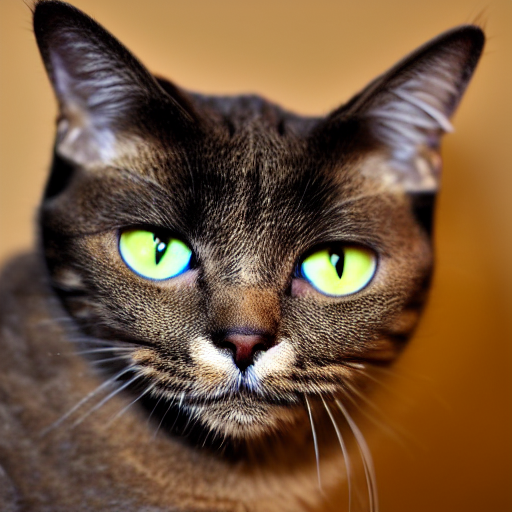

In [ ]:
#@title generate with these modified embeddings

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 30            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

text_embeddings = modified_output_embeddings
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.sigmas[0] # Need to scale to match k

# Loop
with autocast("cuda"):
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

    # predict the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, i, latents)["prev_sample"]

# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents)
  
# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

Suprise! Now you know what token 2368 means ;)

# Textual Inversion

さて、それでは修正したトークン埋め込みベクトルを忍ばせて、これを使って画像を生成してみましょう。この埋め込みベクトルを「学習」してみます。この論文の用語を使うならば、「擬似単語」です。

![Overview image from the blog post](https://textual-inversion.github.io/static/images/training/training.JPG)
_図： [テキスト反転ブログ記事](https://textual-inversion.github.io/static/images/training/training.JPG) - 簡単のために位置埋め込みベクトルのステップを示さないことに注意_

計画は（大まかに）こうです:
- 教えたい概念の入力画像を読み込んでエンコードする
- 置き換えたい単語（トークン）を含むプロンプトを作成する
- そのトークンの埋め込みベクトルを学習中のものに置き換える（図中のv*）
- 画像にノイズを入れる
- ノイズを予測する
- 損失を求める
- 学習中のトークンの埋め込みベクトルに対する損失の勾配を利用して更新する

学習の前に、[Community-created SD concepts library](https://huggingface.co/sd-concepts-library)から新しい「概念」を一つロードして、それが上記の例とどのように適合するかを見てみましょう。最初に作ったものなので、https://huggingface.co/sd-concepts-library/birb-style を使ってみます :) learned_embeds.binをダウンロードし、Colabにアップロードしてから実行します。

In [ ]:
birb_embed = torch.load('/content/learned_embeds.bin')
birb_embed.keys(), birb_embed['<birb-style>'].shape

(dict_keys(['<birb-style>']), torch.Size([768]))

キー（私が使った特別なプレースホルダー、`<birb-style>`）と対応するトークン埋め込みベクトルを持つ辞書が得られます。前の例と同様に、「puppy」というトークン埋め込みベクトルをこれに置き換えて、何が起こるか見てみましょう。

In [ ]:
prompt = 'A mouse in the style of puppy' # Why puppy? We used it before and I'm sticking with it!

# Tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = to_token_embs(input_ids)

# The new embedding, now our special birb token embedding
replacement_token_embedding = birb_embed['<birb-style>']

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
position_embeddings = get_pos_embs()
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

0it [00:00, ?it/s]

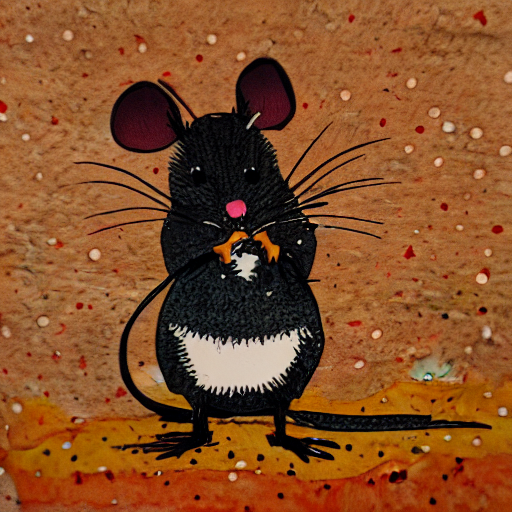

In [ ]:
#@title generate with these modified embeddings

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 30            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

text_embeddings = modified_output_embeddings
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.sigmas[0] # Need to scale to match k

# Loop
with autocast("cuda"):
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

    # predict the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, i, latents)["prev_sample"]

# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents)
  
# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

Hugging Faceからは [a nice inference notebook ](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_conceptualizer_inference.ipynb) が提供されており、ここで進めたマニュアルでのステップを踏まなくとも、新しい名前をプロンプトの中 ("A `<cat-toy>` in the style of `<birb-style>`") 使うことができます。このノートブックのゴールは、裏側で何が起こっているのかを知ってもらうために、カーテンを少し引き下げることです :)

# Training Example

# トレーニングの例

私 (訳者注: Jonathan氏) のトレーニングコードはかなりバギーでした - フィールドトリップから戻るまでこのセクションをTODOとして残します。その間に、自分自身で学習し、それを共有する最良の方法は、おそらく https://huggingface.co/docs/diffusers/main/en/training/text_inversion の hf 例に従うか、他の人々が自分自身のバージョンを行っていないか探すことでしょう。

オーバーフィッティングを減らすために画像を追加したり、あなたのコンセプトに最も合うようにパラメータを調整したり、複雑なアイデアを捕らえるために一度に2つか3つのトークンエンベッディングのグループで作業したり・・・新しい空間です、どんどん挑戦してください。

[AIAIARTコース](https://github.com/johnowhitaker/aiaiart)には、これらのツールの理解を深めるためのレッスンがあります。また、これらすべてをさらに深く掘り下げる新しいコースも近日公開予定ですので、ご期待ください。

どうぞお楽しみに。

J

(日本語訳と編集: [@tomo-makes](https://twitter.com/tomo_makes))